In [3]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from fusiondls.Profile import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [4]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [5]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [6]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [7]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [8]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [9]:
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

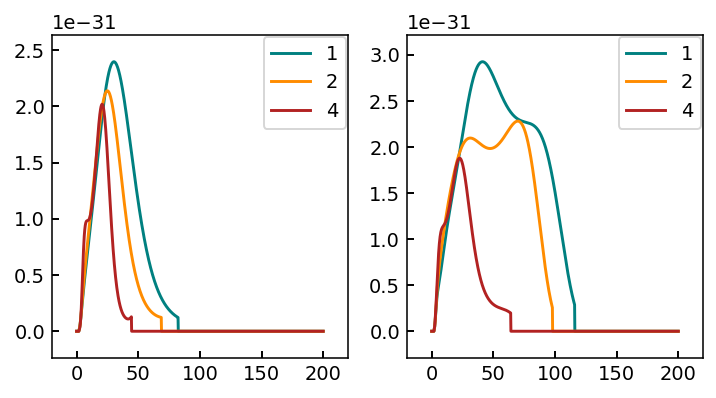

In [10]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [11]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

(-10.0, 200.0)

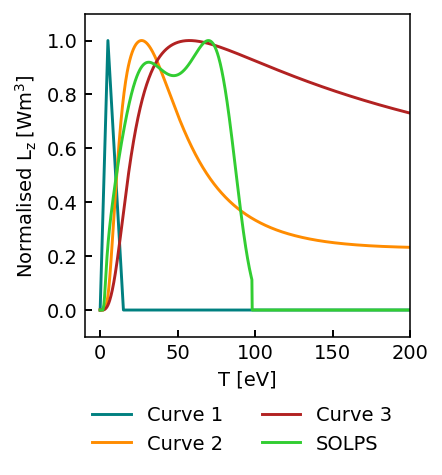

In [12]:
curves["set_outer"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e16],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

(-10.0, 200.0)

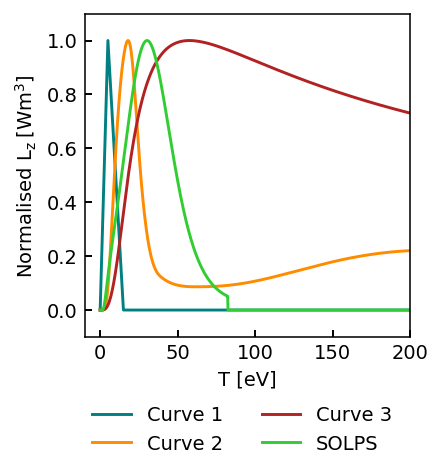

In [13]:
curves["set_inner"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e20],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

# Profile grid

## Make profile function

In [14]:
from fusiondls.Profile import cord_spline
region = "outer_lower"

R_strike = 4
Z_strike = -10

def get_offsets_strike_point(pos, R_strike, Z_strike):
    
    Z_Xpoint = self["Z"][self["Xpoint"]]
    R_Xpoint = self["R"][self["Xpoint"]]

    R_strike_original = self["R"][0]
    Z_strike_original = self["Z"][0]

    cp = pd.DataFrame() # control points
    # cp["pos"] = [1, 0.5, 0.25, 0]
    cp["pos"] = pos

    spl = cord_spline(self.R_leg, self.Z_leg, return_spline=True)

    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        R, Z = spl(pos)
        cp.loc[i, "R"] = R
        cp.loc[i, "Z"] = Z

    strikeOffsetR = R_strike - R_strike_original
    strikeOffsetZ = Z_strike - Z_strike_original

    # cp["Rdist"] = -1* (cp["R"] - R_strike_original) / (cp["R"].iloc[0] - R_strike_original)
    cp["Rdist"] = (R_Xpoint - cp["R"]) / (R_Xpoint - cp["R"].iloc[-1])
    cp["Zdist"] = (Z_Xpoint - cp["Z"]) / (Z_Xpoint - cp["Z"].iloc[-1])
    cp["Rnew"] = cp["R"] + strikeOffsetR * cp["Rdist"]
    cp["Znew"] = cp["Z"] + strikeOffsetZ * cp["Zdist"]
    cp["offsetx"] = cp["Rdist"]
    cp["offsety"] = cp["Zdist"]
    
    
    offsets = []
    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        offsets.append(dict(
            pos = cp.loc[i, "pos"], 
            posx = cp.loc[i, "Rnew"], 
            posy = cp.loc[i, "Znew"],
            # offsetx = cp.loc[i, "offsetx"],
            # offsety = cp.loc[i, "offsety"]
            ))
    return offsets
        


## Make profiles - outer

Text(0.5, 1.0, 'Profile shapes')

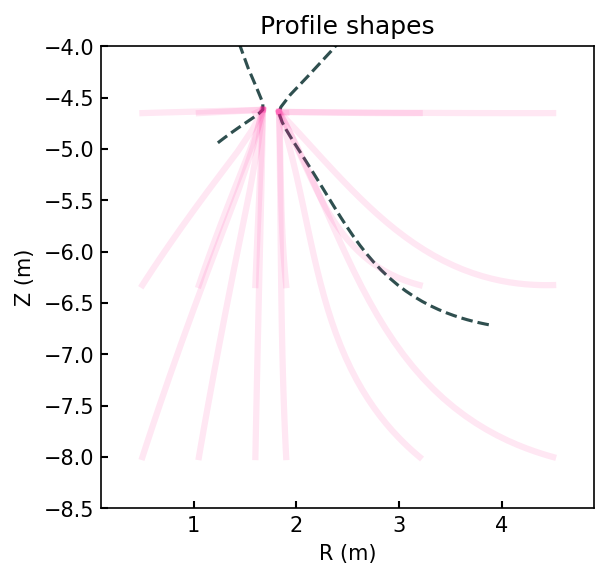

In [18]:
base_profile_inner = eqb_alt['100MW_innerar_midplanepuff']["inner_lower"][sepadd_select["inner_lower"]]
base_profile_outer = eqb_alt['100MW_innerar_midplanepuff']["outer_lower"][sepadd_select["outer_lower"]]

res = 3
xpoints_inner = np.linspace(0.5, 1.6, res)
ypoints_inner = np.linspace(-4.65, -8, res)

xpoints_outer = np.linspace(1.9, 4.5, res)
ypoints_outer = np.linspace(-4.65, -8, res)

profiles_inner = {}
profiles_outer = {}

for x in xpoints_outer:
    profiles_outer[x] = {}
    for y in ypoints_outer:
        p2 = base_profile_outer.copy()
        offsets = p2.get_offsets_strike_point([1, 0.6, 0.59, 0], x, y)
        p2.offset_control_points(offsets, verbose = False)
        p2.recalculate_topology(verbose = False)
        profiles_outer[x][y] = p2
        
for x in xpoints_inner:
    profiles_inner[x] = {}
    for y in ypoints_inner:
        p2 = base_profile_inner.copy()
        offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.1, 0], x, y)
        p2.offset_control_points(offsets, verbose = False)
        p2.recalculate_topology(verbose = False)
        profiles_inner[x][y] = p2

fig, ax = plt.subplots(dpi = 150)
ax.plot(base_profile_inner["R"], base_profile_inner["Z"], ls = "--", c = "darkslategrey")
ax.plot(base_profile_outer["R"], base_profile_outer["Z"], ls = "--", c = "darkslategrey")

for x in xpoints_outer:
    for y in ypoints_outer:
        profiles_outer[x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)
        
for x in xpoints_inner:
    for y in ypoints_inner:
        profiles_inner[x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)

ax.set_ylim(-8.5, -4.0)
# ax.set_xlim(1.5, 8)
# plt.plot(p2["R_original"], p2["Z_original"])
ax.set_aspect("equal")
ax.set_title("Profile shapes")

Text(0.5, 1.05, 'fR and Lc factor parameter space')

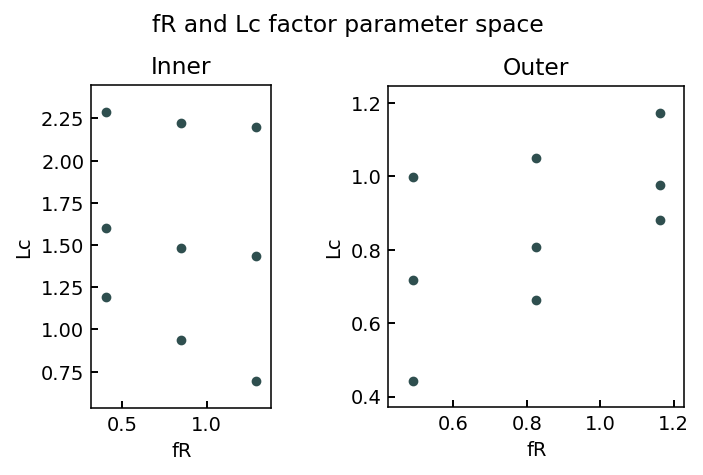

In [19]:
fig, axes = plt.subplots(1,2, figsize=(6,3))

axes[0].set_title("Inner")
for x in xpoints_inner:
    for y in ypoints_inner:
        fR = profiles_inner[x][y].get_total_flux_expansion() / base_profile_inner.get_total_flux_expansion()
        Lc = profiles_inner[x][y].get_connection_length() / base_profile_inner.get_connection_length()
        
        axes[0].plot(fR, Lc, marker = "o", lw = 0, ms = 4, color = "darkslategrey")

axes[1].set_title("Outer")
for x in xpoints_outer:
    for y in ypoints_outer:
        fR = profiles_outer[x][y].get_total_flux_expansion() / base_profile_outer.get_total_flux_expansion()
        Lc = profiles_outer[x][y].get_connection_length() / base_profile_outer.get_connection_length()
        
        axes[1].plot(fR, Lc, marker = "o", lw = 0, ms = 4, color = "darkslategrey")
        

for ax in axes:
    ax.set_xlabel("fR")
    ax.set_ylabel("Lc")
    ax.set_aspect("equal")

fig.suptitle("fR and Lc factor parameter space", y = 1.05)

# Run DLS

In [24]:
def run_DLS(constants_input, profile, Spar, slc, cvar, region, sepadd, hflux_corr=1):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=[Spar],
        qpllu0=3.42e8,
        nu0=nu,
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve(
            "Ar", region, sepadd=sepadd, plot=False
        ),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        Ctol = 1e-4,
        Ttol = 1e-4,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            MagneticGeometry.from_profile(profile),
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Run baseline

## Initialise

In [21]:
nested_dict = lambda: defaultdict(nested_dict)
store_outer = nested_dict()
comps_outer = nested_dict()
store_inner = nested_dict()
comps_inner = nested_dict()
base_outer = {}
base_inner = {}

### Inner

In [26]:
study = "inner"
region = "inner_lower"

for curve in ["Curve 1", "SOLPS"]:

    base_profile_inner = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
    
    input = dict(cooling_curve = curves["set_inner"][curve])
    out, comp = run_DLS(input, base_profile_inner, 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
    base_inner[curve] = out
    

Solving...0.00...Complete in 4.3 seconds
Solving...0.00...Complete in 4.7 seconds


### Outer

In [29]:
study = "outer"
region = "outer_lower"

for curve in ["Curve 1", "SOLPS"]:

    base_profile_outer = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
    
    input = dict(cooling_curve = curves["set_outer"][curve])
    out, comp = run_DLS(input, base_profile_outer, 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
    base_outer[curve] = out
    

Solving...0.00...Complete in 5.8 seconds
Solving...0.00...Complete in 7.4 seconds


## Run profiles

### Inner, Curve 1

In [31]:
study = "inner"
region = "inner_lower"
curve = "Curve 1"

for x in xpoints_inner:   
    for y in ypoints_inner:

        print(f"Solving profile {x:.2f}, {y:.2f} ------")   
        input = dict(cooling_curve = curves["set_inner"][curve])
        out, comp = run_DLS(input, profiles_inner[x][y], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[curve][x][y] = comp
        store_inner[curve][x][y] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 0.50, -4.65 ------
Solving...0.00...Complete in 6.9 seconds
Solving profile 0.50, -6.33 ------
Solving...0.00...Complete in 7.1 seconds
Solving profile 0.50, -8.00 ------
Solving...0.00...Complete in 7.2 seconds
Solving profile 1.05, -4.65 ------
Solving...0.00...Complete in 4.2 seconds
Solving profile 1.05, -6.33 ------
Solving...0.00...Complete in 5.0 seconds
Solving profile 1.05, -8.00 ------
Solving...0.00...Complete in 4.5 seconds
Solving profile 1.60, -4.65 ------
Solving...0.00...Complete in 4.4 seconds
Solving profile 1.60, -6.33 ------
Solving...0.00...Complete in 5.4 seconds
Solving profile 1.60, -8.00 ------
Solving...0.00...Complete in 4.9 seconds


### Inner, SOLPS curve

In [33]:
study = "inner"
region = "inner_lower"
curve = "SOLPS"

for x in xpoints_inner:   
    for y in ypoints_inner:

        print(f"Solving profile {x:.2f}, {y:.2f} ------")   
        input = dict(cooling_curve = curves["set_inner"][curve])
        out, comp = run_DLS(input, profiles_inner[x][y], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_inner[curve][x][y] = comp
        store_inner[curve][x][y] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 0.50, -4.65 ------
Solving...0.00...Complete in 7.3 seconds
Solving profile 0.50, -6.33 ------
Solving...0.00...Complete in 6.7 seconds
Solving profile 0.50, -8.00 ------
Solving...0.00...Complete in 5.6 seconds
Solving profile 1.05, -4.65 ------
Solving...0.00...Complete in 6.1 seconds
Solving profile 1.05, -6.33 ------
Solving...0.00...Complete in 5.8 seconds
Solving profile 1.05, -8.00 ------
Solving...0.00...Complete in 4.8 seconds
Solving profile 1.60, -4.65 ------
Solving...0.00...Complete in 5.8 seconds
Solving profile 1.60, -6.33 ------
Solving...0.00...Complete in 4.1 seconds
Solving profile 1.60, -8.00 ------
Solving...0.00...Complete in 5.2 seconds


### Outer, Curve 1

In [34]:
study = "outer"
region = "outer_lower"
curve = "Curve 1"

for x in xpoints_outer:   
    for y in ypoints_outer:

        print(f"Solving profile {x:.2f}, {y:.2f} ------")   
        input = dict(cooling_curve = curves["set_outer"][curve])
        out, comp = run_DLS(input, profiles_outer[x][y], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[curve][x][y] = comp
        store_outer[curve][x][y] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 1.90, -4.65 ------
Solving...0.00...Complete in 4.4 seconds
Solving profile 1.90, -6.33 ------
Solving...0.00...Complete in 4.4 seconds
Solving profile 1.90, -8.00 ------
Solving...0.00...Complete in 3.9 seconds
Solving profile 3.20, -4.65 ------
Solving...0.00...Complete in 3.6 seconds
Solving profile 3.20, -6.33 ------
Solving...0.00...Complete in 21.7 seconds
Solving profile 3.20, -8.00 ------
Solving...0.00...Complete in 3.6 seconds
Solving profile 4.50, -4.65 ------
Solving...0.00...Complete in 1.2 seconds
Solving profile 4.50, -6.33 ------
Solving...0.00...Complete in 4.5 seconds
Solving profile 4.50, -8.00 ------
Solving...0.00...Complete in 3.2 seconds


### Outer, SOLPS curve

In [35]:
study = "outer"
region = "outer_lower"
curve = "SOLPS"

for x in xpoints_outer:   
    for y in ypoints_outer:

        print(f"Solving profile {x:.2f}, {y:.2f} ------")   
        input = dict(cooling_curve = curves["set_outer"][curve])
        out, comp = run_DLS(input, profiles_outer[x][y], 0, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[curve][x][y] = comp
        store_outer[curve][x][y] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 1.90, -4.65 ------
Solving...0.00...Complete in 10.4 seconds
Solving profile 1.90, -6.33 ------
Solving...0.00...Complete in 5.4 seconds
Solving profile 1.90, -8.00 ------
Solving...0.00...Complete in 4.6 seconds
Solving profile 3.20, -4.65 ------
Solving...0.00...Complete in 2.7 seconds
Solving profile 3.20, -6.33 ------
Solving...0.00...Complete in 3.9 seconds
Solving profile 3.20, -8.00 ------
Solving...0.00...Complete in 4.5 seconds
Solving profile 4.50, -4.65 ------
Solving...0.00...Complete in 3.6 seconds
Solving profile 4.50, -6.33 ------
Solving...0.00...Complete in 5.5 seconds
Solving profile 4.50, -8.00 ------
Solving...0.00...Complete in 4.3 seconds


In [158]:
store_inner.keys()

dict_keys(['Curve 1', 'SOLPS'])

In [37]:

def make_contourf_arrays(study, store, base, xpoints, ypoints):
    study_shape = (len(xpoints), len(ypoints))
    decks = nested_dict()
    basecase = FrontLocation(base[study])

    arrays = {}
    
    for param in ["BxBt", "Lc", "thresholds", "BxBt_relative", "Lc_relative", "thresholds_relative"]:
        arrays[param] = np.zeros(study_shape)
        
    for i, x in enumerate(xpoints):
        for j, y in enumerate(ypoints):

            deck = FrontLocationScan(store[study][x][y])
            threshold = deck.FrontLocations[0]
            
            decks[x][y] = deck

            arrays["BxBt"][j,i] = threshold.stats["BxBt"] 
            arrays["Lc"][j,i] = threshold.stats["cvar"] 
            arrays["thresholds"][j,i] = threshold.stats["Lc"] 
            arrays["BxBt_relative"][j,i] = threshold.stats["BxBt"] / basecase.stats["BxBt"]
            arrays["Lc_relative"][j,i] = threshold.stats["Lc"] / basecase.stats["Lc"]
            arrays["thresholds_relative"][j,i] = threshold.stats["cvar"] / basecase.stats["cvar"]
    
    return arrays

arrays_inner = {}
for study in store_inner.keys():
    print(study)
    arrays_inner[study] = make_contourf_arrays(study, store_inner, base_inner, xpoints_inner, ypoints_inner)
    
arrays_outer = {}
for study in store_outer.keys():
    arrays_outer[study] = make_contourf_arrays(study, store_outer, base_outer, xpoints_outer, ypoints_outer)


Curve 1
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region not available.
SOLPS
Warning, deck contains only one case! Detachment window and unstable region not available.
Warning, deck contains only one case! Detachment window and unstable region 

# 2D plots

## Contour function

In [38]:
def make_contour(ax, xpoints, ypoints, array, datarange, step, cmap = "Pastel1", cbar = True):
    
    levels = np.arange(datarange[0], datarange[1] + step, step) - step/2
    ticks = levels[:-1] + step / 2  # Midpoints of each segment

    cf = ax.contourf(xpoints, ypoints, array, levels = levels, cmap = cmap, norm = create_norm(False, None, *datarange), antialiased = True)
    if cbar:
        cbar = fig.colorbar(cf, ax = ax)
        cbar.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x)))
        cbar.set_ticks(ticks)
    base_profile_outer.plot(mode = "RZ", ax = ax, color = "darkslategrey")
    ax.set_aspect("equal")
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    ax.grid(False)

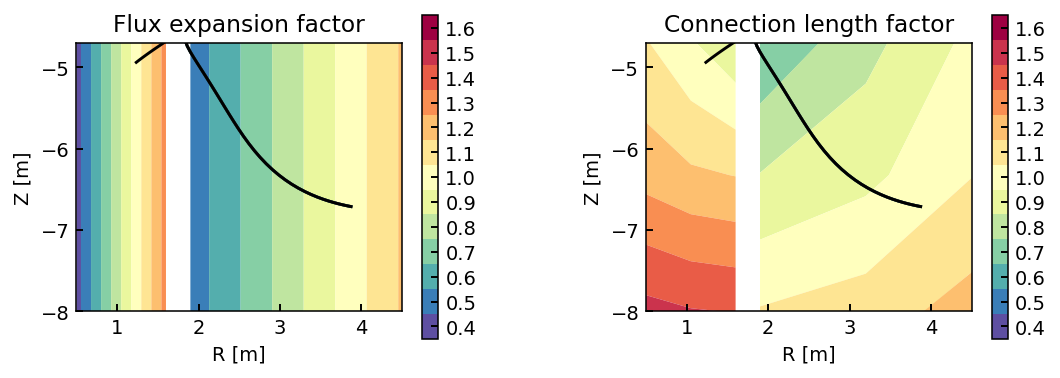

In [39]:
fig, axes = plt.subplots(1,2, figsize = (9,3))

cmap = "Spectral_r"
study = "Curve 1"
datarange = (0.4, 1.6)
step = 0.1

axes[0].set_title("Flux expansion factor")
make_contour(ax = axes[0], xpoints=xpoints_outer, ypoints=ypoints_outer, array = arrays_outer["Curve 1"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints_inner, ypoints=ypoints_inner, array = arrays_inner["Curve 1"]["BxBt_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes[1].set_title("Connection length factor")
make_contour(ax = axes[1], xpoints=xpoints_outer, ypoints=ypoints_outer, array = arrays_outer["Curve 1"]["Lc_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints_inner, ypoints=ypoints_inner, array = arrays_inner["Curve 1"]["Lc_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

for ax in axes:
  base_profile_inner.plot(mode = "RZ", ax = ax, color = "black")
  base_profile_outer.plot(mode = "RZ", ax = ax, color = "black")
  ax.set_aspect("equal")
  ax.set_xlabel("R [m]")
  ax.set_ylabel("Z [m]")
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
  # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
  ax.set_ylim(-8, -4.7)
  ax.set_xlim(0.5, 4.5)
    
fig.subplots_adjust(wspace = 0.4)

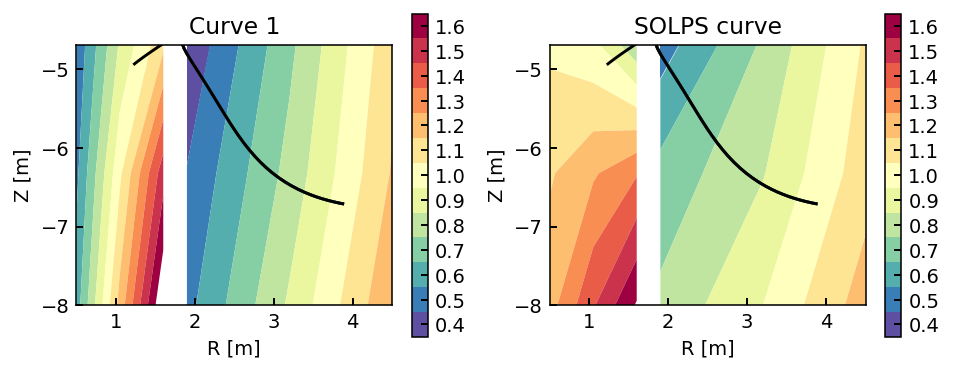

In [40]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

cmap = "Spectral_r"
study = "Curve 1"
datarange = (0.4, 1.6)
step = 0.1

axes[0].set_title("Curve 1")
make_contour(ax = axes[0], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[0], xpoints=xpoints_inner, ypoints=ypoints_inner, array = 1/arrays_inner["Curve 1"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

axes[1].set_title("SOLPS curve")
make_contour(ax = axes[1], xpoints=xpoints_outer, ypoints=ypoints_outer, array = 1/arrays_outer["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap)
make_contour(ax = axes[1], xpoints=xpoints_inner, ypoints=ypoints_inner, array = 1/arrays_inner["SOLPS"]["thresholds_relative"], datarange = datarange, step = step, cmap = cmap, cbar = False)

for ax in axes:
  base_profile_inner.plot(mode = "RZ", ax = ax, color = "black")
  base_profile_outer.plot(mode = "RZ", ax = ax, color = "black")
  ax.set_aspect("equal")
  ax.set_xlabel("R [m]")
  ax.set_ylabel("Z [m]")
  ax.set_ylim(-8, -4.7)
  ax.set_xlim(0.5, 4.5)
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
  # ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
  # ax.grid(which = "major", linestyle = "-", c = "k", alpha = 0.1)
  # ax.grid(which = "minor", c = "k", alpha = 0.05)
fig.subplots_adjust(wspace = 0.2)

